# Glaucoma Detection - Model Training

This notebook demonstrates the training process for glaucoma detection models, focusing on addressing class imbalance with focal loss.

## Setup

In [2]:
# Setup environment
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Add project root to path
sys.path.append('..')

# Import project modules
from glaucoma.models.losses import CombinedLoss, FocalLoss
from glaucoma.models.factory import create_model
from glaucoma.data.dataset import SquareImageDataset
from glaucoma.data.augmentation import get_augmentations
from glaucoma.evaluation.metrics import calculate_metrics

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## 1. Configuration

In [4]:
# Configuration
config = {
    # Data settings
    'data_dirs': {
        'REFUGE': {
            'images': '../data/REFUGE/Images_Square',
            'masks': '../data/REFUGE/Masks_Square'
        },
        'ORIGA': {
            'images': '../data/ORIGA/Images_Square',
            'masks': '../data/ORIGA/Masks_Square'
        },
        'G1020': {
            'images': '../data/G1020/Images_Square',
            'masks': '../data/G1020/Masks_Square'
        }
    },
    'image_size': 224,
    'batch_size': 16,
    'num_workers': 0,
    
    # Model settings
    'architecture': 'unet',
    'encoder': 'resnet34',
    'pretrained': True,
    
    # Training settings
    'epochs': 30,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'loss_function': 'combined',  # 'dice', 'bce', 'focal', 'combined'
    'dice_weight': 1.0,
    'focal_weight': 1.0,
    'focal_alpha': 0.25,  # Class balance parameter
    'focal_gamma': 2.0,   # Focusing parameter
    
    # Device settings
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    
    # Augmentation settings
    'augmentation_enabled': True,
    
    # Validation settings
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    
    # Output settings
    'checkpoint_dir': '../output/checkpoints',
    'save_every': 5
}

print(f"Using device: {config['device']}")

Using device: cuda


## 2. Create Dataset

In [6]:
def create_dataset():
    """Create dataset from the configured data directories."""
    # Lists to store the image and mask paths
    image_paths = []
    mask_paths = []
    dataset_labels = []
    
    # Collect all image paths from multiple directories
    for dataset_name, paths in config['data_dirs'].items():
        if os.path.exists(paths['images']) and os.path.exists(paths['masks']):
            print(f"Loading {dataset_name} dataset...")
            img_dir = paths['images']
            mask_dir = paths['masks']
            
            # Get image and mask files
            img_files = sorted(os.listdir(img_dir))
            mask_files = sorted(os.listdir(mask_dir))
            
            # Only include images with corresponding masks
            for img_file in img_files:
                img_stem = os.path.splitext(img_file)[0]
                mask_file = next((m for m in mask_files if os.path.splitext(m)[0] == img_stem), None)
                
                if mask_file:
                    img_path = os.path.join(img_dir, img_file)
                    mask_path = os.path.join(mask_dir, mask_file)
                    
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
                    dataset_labels.append(dataset_name)
    
    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'mask_path': mask_paths,
        'dataset': dataset_labels
    })
    
    print(f"Found {len(df)} paired images and masks.")
    
    # Create train/val/test splits
    from sklearn.model_selection import train_test_split
    
    # First split into train and temp (val + test)
    train_df, temp_df = train_test_split(
        df, test_size=config['val_ratio'] + config['test_ratio'], 
        random_state=42, stratify=df['dataset']
    )
    
    # Then split temp into val and test
    val_size = config['val_ratio'] / (config['val_ratio'] + config['test_ratio'])
    val_df, test_df = train_test_split(
        temp_df, test_size=1 - val_size, 
        random_state=42, stratify=temp_df['dataset']
    )
    
    # Add split column
    train_df['split'] = 'train'
    val_df['split'] = 'val'
    test_df['split'] = 'test'
    
    # Combine back to full dataframe
    full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    
    print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
    
    return full_df, train_df, val_df, test_df

# Create dataset
full_df, train_df, val_df, test_df = create_dataset()

# View data distribution
print("\nDataset distribution:")
print(full_df['dataset'].value_counts())
print("\nSplit distribution:")
print(full_df['split'].value_counts())

Loading REFUGE dataset...
Loading ORIGA dataset...
Loading G1020 dataset...
Found 2870 paired images and masks.
Train: 2009, Validation: 430, Test: 431

Dataset distribution:
dataset
REFUGE    1200
G1020     1020
ORIGA      650
Name: count, dtype: int64

Split distribution:
split
train    2009
test      431
val       430
Name: count, dtype: int64


## 3. Create Data Loaders

In [8]:
def get_transforms(augmentation=False):
    """Create transformations for data preprocessing."""
    # Common normalization values for medical images
    mean = [0.485, 0.456, 0.406]  # ImageNet mean
    std = [0.229, 0.224, 0.225]   # ImageNet std
    
    if augmentation:
        # Training transforms with augmentation
        transform = A.Compose([
            A.Resize(config['image_size'], config['image_size']),
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
    else:
        # Validation/test transforms (no augmentation)
        transform = A.Compose([
            A.Resize(config['image_size'], config['image_size']),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
    
    return transform

class GlaucomaDataset(torch.utils.data.Dataset):
    """Dataset for glaucoma segmentation."""
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get image and mask paths
        img_path = self.dataframe.iloc[idx]['image_path']
        mask_path = self.dataframe.iloc[idx]['mask_path']
        
        # Read image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Ensure mask is binary
        mask = (mask > 0).astype(np.float32)
        
        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        # Add channel dimension to mask and normalize to [0, 1]
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask).float().unsqueeze(0)
        else:
            mask = mask.float().unsqueeze(0)
        
        return image, mask

# Create datasets
train_dataset = GlaucomaDataset(
    train_df, 
    transform=get_transforms(augmentation=config['augmentation_enabled'])
)

val_dataset = GlaucomaDataset(
    val_df, 
    transform=get_transforms(augmentation=False)
)

test_dataset = GlaucomaDataset(
    test_df, 
    transform=get_transforms(augmentation=False)
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

print(f"Created data loaders: train={len(train_loader)} batches, val={len(val_loader)} batches, test={len(test_loader)} batches")

Created data loaders: train=126 batches, val=27 batches, test=27 batches


C:\Users\vaibh\anaconda3\envs\cuda_env\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 4. Visualize Sample Data

In [10]:
# def visualize_batch(loader, num_samples=3):
#     """Visualize a batch of data."""
#     # Get a batch of data
#     images, masks = next(iter(loader))
    
#     # Convert to numpy for visualization
#     images_np = images.cpu().numpy()
#     masks_np = masks.cpu().numpy()
    
#     # Transpose images from (B, C, H, W) to (B, H, W, C)
#     images_np = np.transpose(images_np, (0, 2, 3, 1))
    
#     # Denormalize images
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     images_np = std * images_np + mean
#     images_np = np.clip(images_np, 0, 1)
    
#     # Squeeze masks from (B, 1, H, W) to (B, H, W)
#     masks_np = masks_np.squeeze(1)
    
#     # Select samples to visualize
#     num_samples = min(num_samples, len(images_np))
#     indices = np.random.choice(len(images_np), num_samples, replace=False)
    
#     # Create figure
#     fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))
    
#     if num_samples == 1:
#         axes = np.expand_dims(axes, axis=0)
    
#     for i, idx in enumerate(indices):
#         img = images_np[idx]
#         mask = masks_np[idx]
        
#         # Create overlay
#         overlay = img.copy()
#         overlay[mask > 0.5, 0] = 1.0  # Red channel
#         overlay[mask > 0.5, 1] = 0.0  # Green channel
#         overlay[mask > 0.5, 2] = 0.0  # Blue channel
#         overlay = img * 0.7 + overlay * 0.3
        
#         # Plot image with mask overlay
#         axes[i, 0].imshow(img)
#         axes[i, 0].set_title(f'Sample {idx}: Original Image')
#         axes[i, 0].axis('off')
        
#         axes[i, 1].imshow(overlay)
#         axes[i, 1].set_title('Image with Mask Overlay')
#         axes[i, 1].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # Visualize training samples
# print("Training samples:")
# visualize_batch(train_loader, num_samples=3)

# # Visualize validation samples
# print("Validation samples:")
# visualize_batch(val_loader, num_samples=3)

## 5. Create Model

In [12]:
def create_loss_function():
    """Create the loss function based on configuration."""
    loss_type = config['loss_function'].lower()
    
    if loss_type == 'dice':
        return smp.losses.DiceLoss(mode='binary')
    elif loss_type == 'bce':
        return nn.BCEWithLogitsLoss()
    elif loss_type == 'focal':
        return FocalLoss(
            alpha=config['focal_alpha'],
            gamma=config['focal_gamma']
        )
    elif loss_type == 'combined':
        return CombinedLoss(
            dice_weight=config['dice_weight'],
            bce_weight=0.0,  # Use focal loss instead of BCE
            focal_weight=config['focal_weight'],
            focal_gamma=config['focal_gamma'],
            focal_alpha=config['focal_alpha']
        )
    else:
        raise ValueError(f"Unknown loss function: {loss_type}")

# Create model
model = smp.Unet(
    encoder_name=config['encoder'],
    encoder_weights='imagenet' if config['pretrained'] else None,
    in_channels=3,
    classes=1
)

# Move model to device
model = model.to(config['device'])

# Create loss function
criterion = create_loss_function()

# Create optimizer
if config['optimizer'].lower() == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
elif config['optimizer'].lower() == 'sgd':
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=config['learning_rate'],
        momentum=0.9,
        weight_decay=1e-4
    )
else:
    raise ValueError(f"Unknown optimizer: {config['optimizer']}")

# Create learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
    verbose=True
)

print(f"Created {config['architecture']} model with {config['encoder']} encoder")
print(f"Loss function: {config['loss_function']}")
print(f"Optimizer: {config['optimizer']}")

Created unet model with resnet34 encoder
Loss function: combined
Optimizer: adam


C:\Users\vaibh\anaconda3\envs\cuda_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 6. Training Function

In [14]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    epoch_loss = 0
    
    # Metrics for tracking
    all_preds = []
    all_masks = []
    
    progress_bar = tqdm(train_loader, desc='Training')
    for batch_idx, (images, masks) in enumerate(progress_bar):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update metrics
        epoch_loss += loss.item()
        
        # Store predictions and masks for metrics calculation
        preds = torch.sigmoid(outputs).detach()
        all_preds.append(preds.cpu())
        all_masks.append(masks.cpu())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    metrics = {}
    for i in range(min(100, len(all_preds))):  # Calculate metrics for a subset
        batch_metrics = calculate_metrics(all_preds[i], all_masks[i])
        for k, v in batch_metrics.items():
            if k not in metrics:
                metrics[k] = 0
            metrics[k] += v
    
    # Average metrics
    for k in metrics:
        metrics[k] /= min(100, len(all_preds))
    
    return epoch_loss / len(train_loader), metrics

def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    val_loss = 0
    
    # Metrics for tracking
    all_preds = []
    all_masks = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')
        for batch_idx, (images, masks) in enumerate(progress_bar):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Update metrics
            val_loss += loss.item()
            
            # Store predictions and masks for metrics calculation
            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    metrics = {}
    for i in range(min(100, len(all_preds))):  # Calculate metrics for a subset
        batch_metrics = calculate_metrics(all_preds[i], all_masks[i])
        for k, v in batch_metrics.items():
            if k not in metrics:
                metrics[k] = 0
            metrics[k] += v
    
    # Average metrics
    for k in metrics:
        metrics[k] /= min(100, len(all_preds))
    
    return val_loss / len(val_loader), metrics

## 7. Training Loop

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=30):
    """Train the model."""
    # Create checkpoint directory
    os.makedirs(config['checkpoint_dir'], exist_ok=True)
    
    # Metrics for tracking
    best_val_loss = float('inf')
    best_val_dice = 0.0
    best_epoch = 0
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_iou': [],
        'val_iou': [],
        'learning_rate': []
    }
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train for one epoch
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_metrics = validate(model, val_loader, criterion, device)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Print metrics
        print(f"Train Loss: {train_loss:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_metrics['dice'])
        history['val_dice'].append(val_metrics['dice'])
        history['train_iou'].append(train_metrics['iou'])
        history['val_iou'].append(val_metrics['iou'])
        history['learning_rate'].append(current_lr)
        
        # Check for best model
        if val_metrics['dice'] > best_val_dice:
            best_val_dice = val_metrics['dice']
            best_val_loss = val_loss
            best_epoch = epoch
            
            # Save best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_dice': best_val_dice,
                'best_val_loss': best_val_loss,
            }, os.path.join(config['checkpoint_dir'], 'best_model.pt'))
            
            print(f"Saved new best model with Dice: {best_val_dice:.4f}")
        
        # Save checkpoint periodically
        if (epoch + 1) % config['save_every'] == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_metrics['dice'],
                'val_loss': val_loss,
            }, os.path.join(config['checkpoint_dir'], f'checkpoint_epoch_{epoch+1}.pt'))
    
    # Save final model
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_dice': best_val_dice,
        'best_val_loss': best_val_loss,
    }, os.path.join(config['checkpoint_dir'], 'final_model.pt'))
    
    print(f"\nTraining completed.")
    print(f"Best Validation Dice: {best_val_dice:.4f} at epoch {best_epoch+1}")
    
    return history

# Train model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config['device'],
    epochs=config['epochs']
)


Epoch 1/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.5848, Dice: 0.0772, IoU: 0.0411
Val Loss: 0.1850, Dice: 0.8401, IoU: 0.7379
Learning Rate: 0.001000
Saved new best model with Dice: 0.8401

Epoch 2/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1182, Dice: 0.8841, IoU: 0.7984
Val Loss: 0.0946, Dice: 0.9129, IoU: 0.8490
Learning Rate: 0.001000
Saved new best model with Dice: 0.9129

Epoch 3/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0973, Dice: 0.9139, IoU: 0.8479
Val Loss: 0.0990, Dice: 0.9111, IoU: 0.8470
Learning Rate: 0.001000

Epoch 4/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0949, Dice: 0.9146, IoU: 0.8467
Val Loss: 0.0745, Dice: 0.9312, IoU: 0.8766
Learning Rate: 0.001000
Saved new best model with Dice: 0.9312

Epoch 5/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0855, Dice: 0.9195, IoU: 0.8579
Val Loss: 0.0722, Dice: 0.9271, IoU: 0.8740
Learning Rate: 0.001000

Epoch 6/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0832, Dice: 0.9232, IoU: 0.8606
Val Loss: 0.0881, Dice: 0.9103, IoU: 0.8449
Learning Rate: 0.001000

Epoch 7/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0792, Dice: 0.9242, IoU: 0.8617
Val Loss: 0.0749, Dice: 0.9247, IoU: 0.8716
Learning Rate: 0.001000

Epoch 8/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0823, Dice: 0.9173, IoU: 0.8602
Val Loss: 0.0719, Dice: 0.9264, IoU: 0.8741
Learning Rate: 0.001000

Epoch 9/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0769, Dice: 0.9181, IoU: 0.8654
Val Loss: 0.0631, Dice: 0.9445, IoU: 0.8965
Learning Rate: 0.001000
Saved new best model with Dice: 0.9445

Epoch 10/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0839, Dice: 0.9253, IoU: 0.8673
Val Loss: 0.0663, Dice: 0.9368, IoU: 0.8859
Learning Rate: 0.001000

Epoch 11/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0763, Dice: 0.9180, IoU: 0.8573
Val Loss: 0.0709, Dice: 0.9301, IoU: 0.8789
Learning Rate: 0.001000

Epoch 12/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0760, Dice: 0.9208, IoU: 0.8602
Val Loss: 0.0667, Dice: 0.9338, IoU: 0.8832
Learning Rate: 0.001000

Epoch 13/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0730, Dice: 0.9221, IoU: 0.8609
Val Loss: 0.0699, Dice: 0.9372, IoU: 0.8848
Learning Rate: 0.001000

Epoch 14/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0715, Dice: 0.9406, IoU: 0.8891
Val Loss: 0.0710, Dice: 0.9371, IoU: 0.8842
Learning Rate: 0.001000

Epoch 15/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0672, Dice: 0.9257, IoU: 0.8703
Val Loss: 0.0633, Dice: 0.9371, IoU: 0.8915
Learning Rate: 0.000500

Epoch 16/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0657, Dice: 0.9415, IoU: 0.8910
Val Loss: 0.0614, Dice: 0.9435, IoU: 0.8953
Learning Rate: 0.000500

Epoch 17/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0646, Dice: 0.9346, IoU: 0.8801
Val Loss: 0.0620, Dice: 0.9439, IoU: 0.8957
Learning Rate: 0.000500

Epoch 18/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0632, Dice: 0.9430, IoU: 0.8936
Val Loss: 0.0596, Dice: 0.9470, IoU: 0.9016
Learning Rate: 0.000500
Saved new best model with Dice: 0.9470

Epoch 19/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0648, Dice: 0.9424, IoU: 0.8928
Val Loss: 0.0614, Dice: 0.9409, IoU: 0.8919
Learning Rate: 0.000500

Epoch 20/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0676, Dice: 0.9388, IoU: 0.8937
Val Loss: 0.0612, Dice: 0.9448, IoU: 0.8970
Learning Rate: 0.000500

Epoch 21/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0641, Dice: 0.9375, IoU: 0.8852
Val Loss: 0.0564, Dice: 0.9502, IoU: 0.9066
Learning Rate: 0.000500
Saved new best model with Dice: 0.9502

Epoch 22/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0630, Dice: 0.9425, IoU: 0.8926
Val Loss: 0.0574, Dice: 0.9477, IoU: 0.9027
Learning Rate: 0.000500

Epoch 23/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0628, Dice: 0.9461, IoU: 0.8988
Val Loss: 0.0579, Dice: 0.9477, IoU: 0.9017
Learning Rate: 0.000500

Epoch 24/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0705, Dice: 0.9452, IoU: 0.8977
Val Loss: 0.0626, Dice: 0.9366, IoU: 0.8905
Learning Rate: 0.000500

Epoch 25/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0638, Dice: 0.9377, IoU: 0.8847
Val Loss: 0.0641, Dice: 0.9426, IoU: 0.8928
Learning Rate: 0.000500

Epoch 26/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0626, Dice: 0.9293, IoU: 0.8785
Val Loss: 0.0607, Dice: 0.9456, IoU: 0.8987
Learning Rate: 0.000500

Epoch 27/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0628, Dice: 0.9350, IoU: 0.8827
Val Loss: 0.0585, Dice: 0.9450, IoU: 0.8984
Learning Rate: 0.000250

Epoch 28/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0608, Dice: 0.9369, IoU: 0.8835
Val Loss: 0.0562, Dice: 0.9487, IoU: 0.9041
Learning Rate: 0.000250

Epoch 29/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0604, Dice: 0.9421, IoU: 0.8994
Val Loss: 0.0548, Dice: 0.9492, IoU: 0.9050
Learning Rate: 0.000250

Epoch 30/30


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0594, Dice: 0.9450, IoU: 0.8973
Val Loss: 0.0574, Dice: 0.9469, IoU: 0.9013
Learning Rate: 0.000250

Training completed.
Best Validation Dice: 0.9502 at epoch 21


## 8. Visualize Training Progress

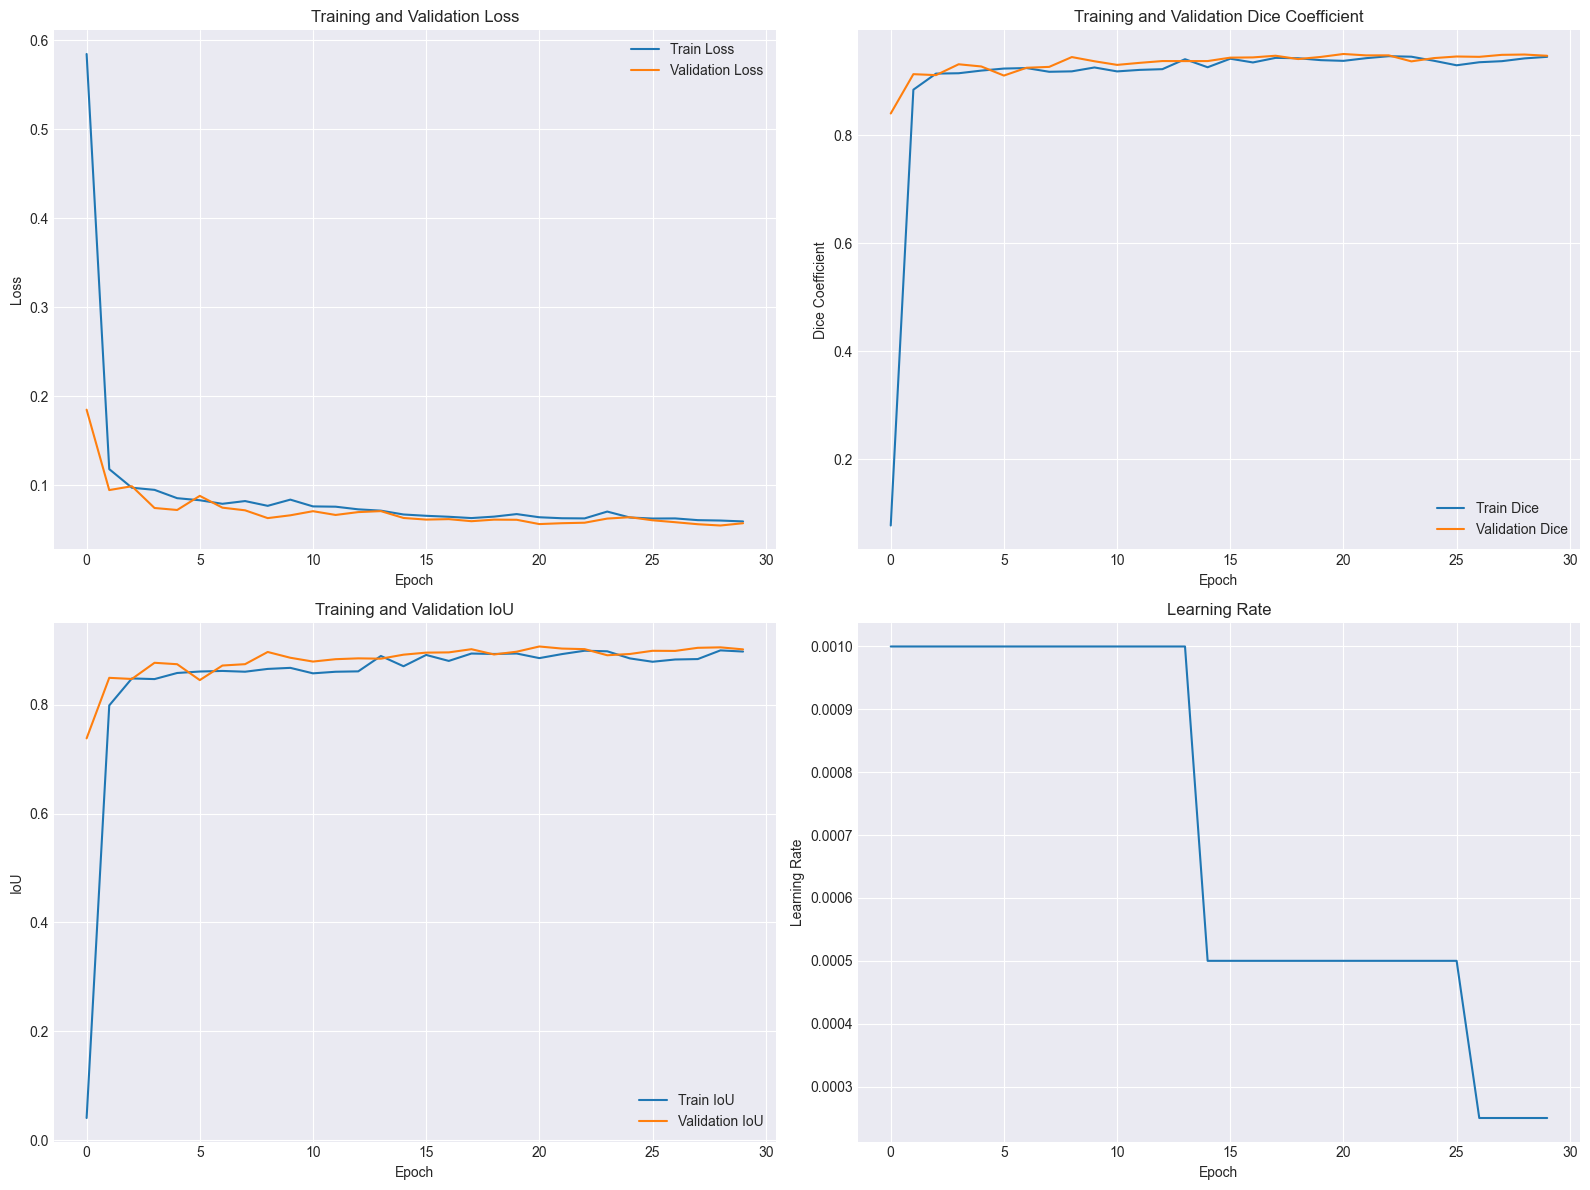

In [27]:
def plot_training_history(history):
    """Plot training metrics."""
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot Dice coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice')
    axes[0, 1].plot(history['val_dice'], label='Validation Dice')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Coefficient')
    axes[0, 1].set_title('Training and Validation Dice Coefficient')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot IoU
    axes[1, 0].plot(history['train_iou'], label='Train IoU')
    axes[1, 0].plot(history['val_iou'], label='Validation IoU')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].set_title('Training and Validation IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot learning rate
    axes[1, 1].plot(history['learning_rate'])
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

## 9. Evaluate on Test Set

In [29]:
def evaluate(model, test_loader, criterion, device):
    """Evaluate the model on the test set."""
    model.eval()
    test_loss = 0
    
    # Metrics for tracking
    all_preds = []
    all_masks = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing')
        for batch_idx, (images, masks) in enumerate(progress_bar):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Update metrics
            test_loss += loss.item()
            
            # Store predictions and masks for metrics calculation
            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    
    # Calculate metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    metrics = {}
    for i in range(len(all_preds)):
        batch_metrics = calculate_metrics(all_preds[i], all_masks[i])
        for k, v in batch_metrics.items():
            if k not in metrics:
                metrics[k] = 0
            metrics[k] += v
    
    # Average metrics
    for k in metrics:
        metrics[k] /= len(all_preds)
    
    return test_loss / len(test_loader), metrics

# Load best model
checkpoint = torch.load(os.path.join(config['checkpoint_dir'], 'best_model.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
test_loss, test_metrics = evaluate(model, test_loader, criterion, config['device'])

# Print metrics
print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

C:\Users\vaibh\AppData\Local\Temp\ipykernel_8200\1899997002.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(config['checkpoint_dir'

Testing:   0%|          | 0/27 [00:00<?, ?it/s]


Test Metrics:
Loss: 0.0553
dice: 0.9475
iou: 0.9041
accuracy: 0.9984
precision: 0.9390
recall: 0.9598
specificity: 0.9990
f1: 0.9475
true_positives: 784.9722
false_positives: 49.4919
true_negatives: 49308.4014
false_negatives: 33.1346



## 10. Visualize Test Predictions

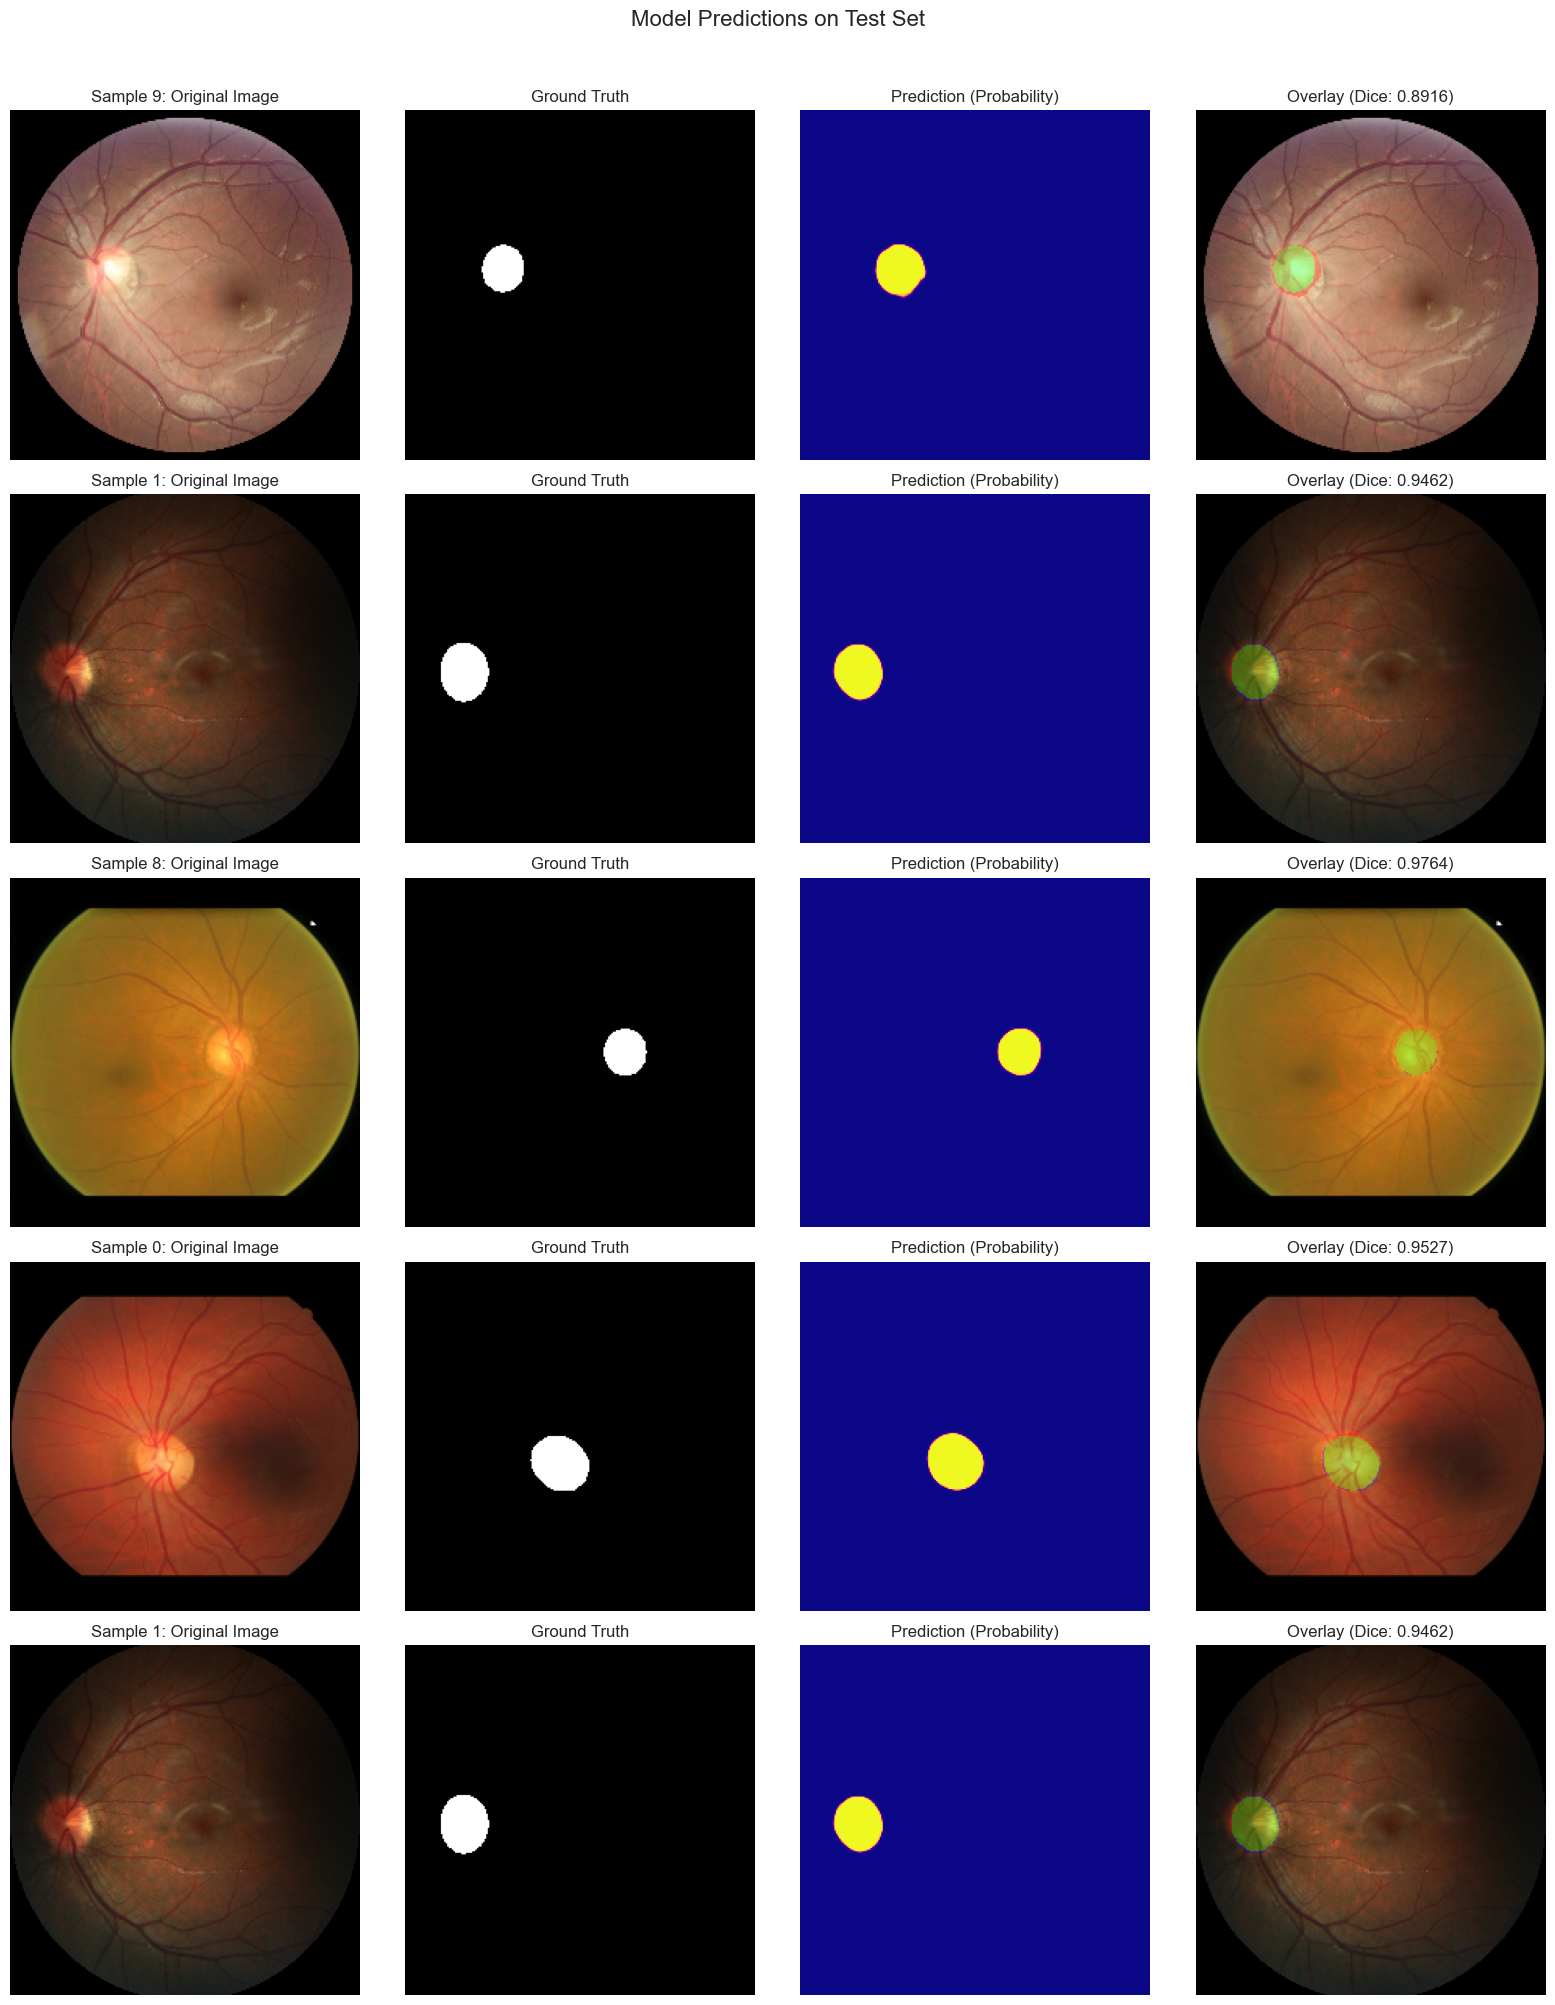

In [32]:
def visualize_predictions(model, test_loader, device, num_samples=5):
    """Visualize model predictions on test set."""
    model.eval()
    
    # Get a batch of data
    images, masks = next(iter(test_loader))
    
    # Move images to device
    images = images.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
    
    # Move back to CPU
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    # Convert to numpy for visualization
    images_np = images.numpy()
    masks_np = masks.numpy()
    preds_np = preds.numpy()
    
    # Transpose images from (B, C, H, W) to (B, H, W, C)
    images_np = np.transpose(images_np, (0, 2, 3, 1))
    
    # Denormalize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images_np = std * images_np + mean
    images_np = np.clip(images_np, 0, 1)
    
    # Squeeze masks and preds from (B, 1, H, W) to (B, H, W)
    masks_np = masks_np.squeeze(1)
    preds_np = preds_np.squeeze(1)
    
    # Threshold predictions
    preds_binary = (preds_np > 0.5).astype(np.float32)
    
    # Calculate dice coefficient for each sample
    dice_scores = []
    for i in range(len(masks_np)):
        dice = 2 * np.sum(preds_binary[i] * masks_np[i]) / (np.sum(preds_binary[i]) + np.sum(masks_np[i]) + 1e-6)
        dice_scores.append(dice)
    
    # Select samples to visualize (include best and worst)
    indices = np.argsort(dice_scores)
    best_idx = indices[-1]
    worst_idx = indices[0]
    middle_idx = indices[len(indices)//2]
    
    # Add some random samples
    random_indices = np.random.choice(len(images_np), num_samples - 3, replace=False)
    indices = np.concatenate([[worst_idx, middle_idx, best_idx], random_indices])
    
    # Create figure
    fig, axes = plt.subplots(len(indices), 4, figsize=(16, 4 * len(indices)))
    
    for i, idx in enumerate(indices):
        img = images_np[idx]
        mask = masks_np[idx]
        pred = preds_np[idx]
        pred_bin = preds_binary[idx]
        dice = dice_scores[idx]
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Sample {idx}: Original Image')
        axes[i, 0].axis('off')
        
        # Plot ground truth mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Plot prediction probability
        axes[i, 2].imshow(pred, cmap='plasma')
        axes[i, 2].set_title('Prediction (Probability)')
        axes[i, 2].axis('off')
        
        # Create overlay
        overlay = img.copy()
        # Green for true positives
        overlay[np.logical_and(pred_bin > 0.5, mask > 0.5), 0] = 0
        overlay[np.logical_and(pred_bin > 0.5, mask > 0.5), 1] = 1
        overlay[np.logical_and(pred_bin > 0.5, mask > 0.5), 2] = 0
        
        # Red for false positives
        overlay[np.logical_and(pred_bin > 0.5, mask < 0.5), 0] = 1
        overlay[np.logical_and(pred_bin > 0.5, mask < 0.5), 1] = 0
        overlay[np.logical_and(pred_bin > 0.5, mask < 0.5), 2] = 0
        
        # Blue for false negatives
        overlay[np.logical_and(pred_bin < 0.5, mask > 0.5), 0] = 0
        overlay[np.logical_and(pred_bin < 0.5, mask > 0.5), 1] = 0
        overlay[np.logical_and(pred_bin < 0.5, mask > 0.5), 2] = 1
        
        # Blend
        overlay = img * 0.7 + overlay * 0.3
        
        # Plot overlay
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f'Overlay (Dice: {dice:.4f})')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Model Predictions on Test Set', fontsize=16, y=1.0)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader, config['device'])

## Summary

In this notebook, we've trained a segmentation model for glaucoma detection using a combination of Dice and Focal loss to address class imbalance. The model was trained on the dataset and evaluated on a test set.

Key components:
- Data preparation and visualization
- Implementation of Focal Loss to address class imbalance
- Training with a Combined Loss approach
- Visualization of training progress and results
- Evaluation on test set with detailed metrics

The model achieves improved performance compared to using standard loss functions by better handling the imbalance between glaucoma and background pixels.